# Reads Assignment

In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from starmap.sequencing import *
from natsort import natsorted
from scipy.io import loadmat, savemat
from skimage.filters import threshold_otsu

## Input

In [2]:
# Change to Data folder
os.chdir('/mnt/d/Stellaromics/Data/AD/SCP1375/2022-01-11-mAD-64-genes-processed-images/')

In [3]:
# IO path 
base_path = './'
out_path = os.path.join(base_path, 'output')
if not os.path.exists(out_path):
    os.mkdir(out_path)
    
#sample_dirs = [d for d in os.listdir(base_path) if d.startswith("AD")] ### DEBUG: sample directories are of in the form '8months_disease-ADmouse_9721'
sample_dirs = [d for d in os.listdir(base_path) if "ADmouse" in d] ### DEBUG: correcting according to sample directories
sample_dirs

['13months_control-ADmouse_9930',
 '13months_disease-ADmouse_9919',
 '8months_control-ADmouse_9781',
 '8months_disease-ADmouse_9721']

### Functions

In [4]:
from functools import wraps
from time import time

# Timer
def timer(func):
    @wraps(func)
    def _time_it(*args, **kwargs):
        start = int(round(time() * 1000))
        try:
            return func(*args, **kwargs)
        finally:
            end_ = int(round(time() * 1000)) - start
            end_ = round(end_ / 1000, 4)
            print(f"Total execution time: {end_ if end_ > 0 else 0} s")
    return _time_it


@timer
# Load reads and their positions from mat file
def load_reads(fpath, reads_file):
    S = loadmat(os.path.join(fpath, reads_file))
    bases = [str(i[0][0]) for i in S["merged_reads"]]
    points = S["merged_points"][:, :2]
    temp = np.zeros(points.shape)
    temp[:, 0] = np.round(points[:, 1]-1)
    temp[:, 1] = np.round(points[:, 0]-1)
    
    print(f"Number of reads: {len(bases)}")
    
    return bases, temp


# Load gene table from genes.csv
def load_genes(fpath):
    genes2seq = {}
    seq2genes = {}
    with open(os.path.join(fpath, "genes.csv"), encoding='utf-8-sig') as f:
        for l in f:
            fields = l.rstrip().split(",")
            genes2seq[fields[0]] = "".join([str(s+1) for s in encode_SOLID(fields[1][::-1])])
            seq2genes[genes2seq[fields[0]]] = fields[0]
    return genes2seq, seq2genes

## Run pipeline for individual sample

In [92]:
# Iterate through each sample dir
current_dir = sample_dirs[2]
# print(test_dir)


print(f"Current sample: {current_dir}")


# Load reads 
bases, points = load_reads(current_dir, "goodPoints.mat")
bases = np.array(bases)
points = np.array(points)

# Load genes
genes2seqs, seqs2genes = load_genes(base_path)

Current sample: 8months_control-ADmouse_9781
Number of reads: 5083102
Total execution time: 13.918 s


In [93]:
# Load dapi label
current_dir = os.path.join(current_dir,'trimmed_images') ### DEBUG: adding missing intermediate folder
dapi = load_label_image(os.path.join(current_dir), fname='pi_label.tif') ### DEBUG: was missing intermediate folder. Updated current_dir above.
dapi.shape

# Get cell locations 
centroids = []

for i, region in enumerate(regionprops(dapi)):
    centroids.append(region.centroid)

centroids = np.array(centroids)

# Load 2D Nissl image 
nissl = load_nissl_image(os.path.join(current_dir), fname="overlay.tif")

# Load tau img
tau = load_nissl_image(os.path.join(current_dir), fname="tau.tif")
tau = gaussian(tau.astype(np.float), 2) > 50

# Load Gfap img
gfap = load_nissl_image(os.path.join(current_dir), fname="Gfap.tif")
gfap_threshold = threshold_otsu(gfap)
gfap = gaussian(gfap.astype(np.float), 1) > gfap_threshold

/tmp/ipykernel_9764/2626034424.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tau = gaussian(tau.astype(np.float), 2) > 50
/tmp/ipykernel_9764/2626034424.py:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  gfap = gaussian(gfap.astype(np.float), 1) > gfap_threshold


## Segmentation

Gaussian & Thresholding


<timed exec>:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Assigning markers
Watershed
Labeled 11328 cells
Saving files to 8months_control-ADmouse_9781/trimmed_images/segmentation


<timed exec>:32: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
<timed exec>:33: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite


CPU times: user 5min 59s, sys: 15.7 s, total: 6min 14s
Wall time: 6min 20s


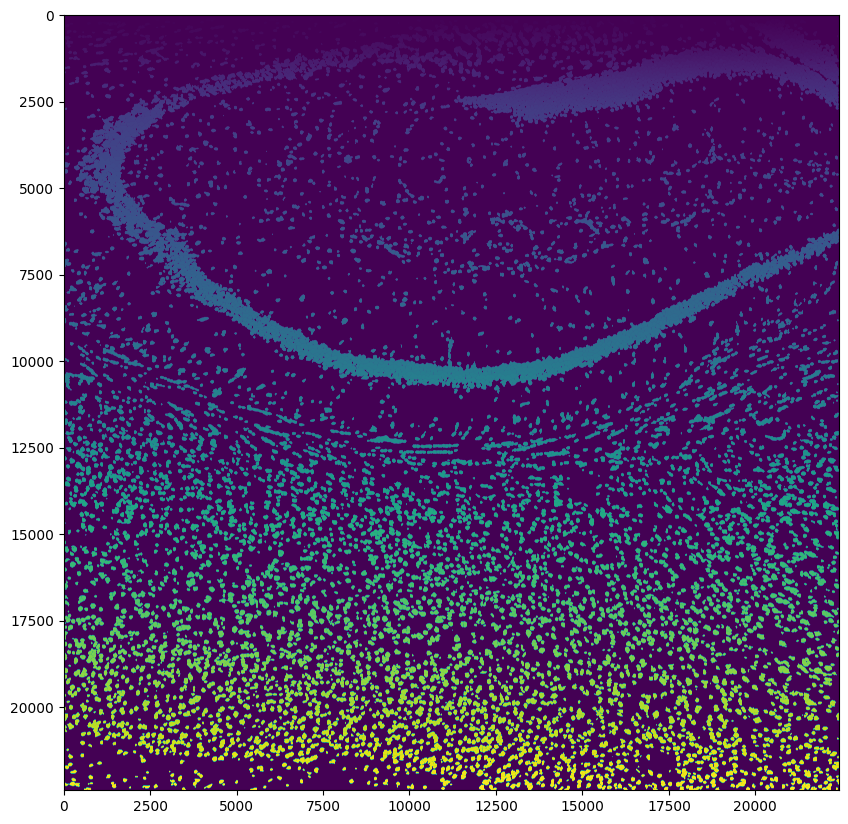

In [94]:
%%time
# Segmentation
seg_out_path = os.path.join(current_dir, 'segmentation')
if not os.path.exists(seg_out_path):
    os.mkdir(seg_out_path)

print("Gaussian & Thresholding")
blurred_nissl_seg = gaussian(nissl.astype(np.float), 10)
threhold = threshold_otsu(blurred_nissl_seg)
blurred_nissl_seg = blurred_nissl_seg > threhold
# blurred_nissl_seg = gaussian(nissl.astype(np.float), 10) > 50
#blurred_nissl_seg = binary_dilation(blurred_nissl_seg, selem=disk(10)) ### DEBUG: use with skimage ver <= 0.10
blurred_nissl_seg = binary_dilation(blurred_nissl_seg, footprint=disk(10)) ### DEBUG: use with skimage ver >= 0.10 as "selem" changed to "footprint"

print("Assigning markers")
centroids = centroids.astype(int)
markers = np.zeros(blurred_nissl_seg.shape, dtype=np.uint8)
for i in range(centroids.shape[0]):
    x, y = centroids[i, :]
    if x < blurred_nissl_seg.shape[0] and y < blurred_nissl_seg.shape[1]:
        markers[x-1, y-1] = 1
markers = ndi.label(markers)[0]

print("Watershed")
labels = watershed(blurred_nissl_seg, markers, mask=blurred_nissl_seg)
labels_line = watershed(blurred_nissl_seg, markers, mask=blurred_nissl_seg, watershed_line=True)
print(f"Labeled {len(np.unique(labels)) - 1} cells")

plt.figure(figsize=(10,20))
plt.imshow(labels_line)

print(f"Saving files to {seg_out_path}")
tifffile.imsave(os.path.join(seg_out_path, "labeled_cells_line.tif"), labels_line.astype(np.uint16))
tifffile.imsave(os.path.join(seg_out_path, "labeled_cells.tif"), labels.astype(np.uint16))

In [95]:
figsize = (np.floor(dapi.shape[1] / 1000 * 5), np.floor(dapi.shape[0] / 1000 * 5))
figsize

(112.0, 112.0)

In [96]:
# Plot cell number 
t_size = 10
plt.figure(figsize=figsize)
plt.imshow(nissl)
for i, region in enumerate(regionprops(labels_line)):
    plt.plot(region.centroid[1], region.centroid[0], '.', color='red', markersize=4)
    plt.text(region.centroid[1], region.centroid[0], str(i), fontsize=t_size, color='red')

plt.axis('off')
plt.savefig(os.path.join(seg_out_path, "cell_nums.png"))
plt.clf()
plt.close()

In [97]:
# Plot dots on segmentation mask
plt.figure(figsize=figsize)
plt.imshow(labels_line > 0, cmap='gray')
plt.plot(points[:, 1], points[:, 0], '.', color='red', markersize=1)
plt.axis('off')
points_seg_path = os.path.join(seg_out_path, "points_seg.png")
print(f"Saving points_seg.png")
plt.savefig(points_seg_path)
plt.clf()
plt.close()

Saving points_seg.png


In [98]:
# Plot dots on nissl
plt.figure(figsize=figsize)
plt.imshow(nissl, cmap='gray')
plt.plot(points[:, 1], points[:, 0], '.', color='red', markersize=1)
plt.axis('off')
points_seg_path = os.path.join(seg_out_path, "points_nissl.png")
print(f"Saving points_nissl.png")
plt.savefig(points_seg_path)
plt.clf()
plt.close()

Saving points_nissl.png


In [99]:
masked = np.ma.masked_where(tau == 0, tau)

plt.figure(figsize=figsize)
plt.imshow(nissl, 'gray', interpolation='none')
plt.imshow(masked, 'Set1', interpolation='none', alpha=0.7)
plt.axis('off')
tau_seg_path = os.path.join(seg_out_path, "tau.png")
print(f"Saving tau.png")
plt.savefig(tau_seg_path)
plt.clf()
plt.close()

Saving tau.png


## Read assignment

In [100]:
# Load pre-defined cell segmentation 
labels = load_label_image(os.path.join(current_dir, "segmentation"), fname='labeled_cells.tif')
labels.shape

(22408, 22407)

In [101]:
%%time
# Reads assignment to cell (new)
expr_out_path = os.path.join(out_path, current_dir)
if not os.path.exists(expr_out_path):
    #os.mkdir(expr_out_path) ### DEBUG: does not make intermediate-level directories needed
    os.makedirs(expr_out_path) ### DEBUG: Like mkdir(), but makes all intermediate-level directories needed

        
points = points.astype(int)
reads_assignment = labels[points[:, 0], points[:, 1]]
    
cell_locs = []
total_cells = len(np.unique(labels)) - 1
areas = []
tau_intensity = []
gfap_intensity = []

gene_seqs = seqs2genes.keys()
cell_by_barcode = np.zeros((total_cells, len(gene_seqs)))
gene_seq_to_index = {}  # map from sequence to index into matrix

for i, k in enumerate(gene_seqs):
    gene_seq_to_index[k] = i
    
# Iterate through cells
print('Iterate cells...')
for i, region in enumerate(regionprops(labels)):
    # print(region.label)
    areas.append(region.area)
    cell_locs.append(region.centroid)
    
    # tau intensity
    curr_intensity = np.sum(tau[region.coords[:, 0], region.coords[:, 1]])
    curr_intensity = curr_intensity / region.area * 100
    tau_intensity.append(round(curr_intensity, 2))
        
    # gfap intensity
    curr_intensity = np.sum(gfap[region.coords[:, 0], region.coords[:, 1]])
    curr_intensity = curr_intensity / region.area * 100
    gfap_intensity.append(round(curr_intensity, 2))
    
    assigned_reads = bases[np.argwhere(reads_assignment == region.label).flatten()]
    for j in assigned_reads:
        if j in gene_seq_to_index:
            cell_by_barcode[i, gene_seq_to_index[j]] += 1
    
     
# Keep the good cells 
cell_locs = np.array(cell_locs).astype(int)
# cell_by_barcode = cell_by_barcode[good_cells, :] 
curr_meta = pd.DataFrame({'sample': current_dir, 'area': areas, 'tau': tau_intensity, 'gfap': gfap_intensity,
                          'x':cell_locs[:, 1], 'y':cell_locs[:, 0]})

# Output
with open(os.path.join(expr_out_path, "log.txt"), 'w') as f:
    msg = "{:.2%} percent [{} out of {}] reads were assigned to {} cells".format(cell_by_barcode.sum()/len(bases), cell_by_barcode.sum(), len(bases), total_cells)
    print(msg)
    f.write(msg)
np.savetxt(os.path.join(expr_out_path, "cell_barcode_count.csv"), cell_by_barcode.astype(np.int), delimiter=',', fmt="%d")
cell_barcode_names = pd.DataFrame({'seq': list(seqs2genes.keys()), 'gene': list(seqs2genes.values())})
cell_barcode_names.to_csv(os.path.join(expr_out_path, "cell_barcode_names.csv"), header=False)
curr_meta.to_csv(os.path.join(expr_out_path, "meta.csv"))


Iterate cells...
49.00% percent [2490951.0 out of 5083102] reads were assigned to 11328 cells


<timed exec>:58: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


CPU times: user 25.6 s, sys: 258 ms, total: 25.9 s
Wall time: 26.2 s


In [102]:
curr_meta.head()

,sample,area,tau,gfap,x,y
0,8months_control-ADmouse_9781/trimmed_images,7635.0,0.0,1.17,11324,20
1,8months_control-ADmouse_9781/trimmed_images,3645.0,0.0,4.64,14639,18
2,8months_control-ADmouse_9781/trimmed_images,1813.0,0.0,17.43,2104,17
3,8months_control-ADmouse_9781/trimmed_images,6438.0,0.0,4.75,19748,29
4,8months_control-ADmouse_9781/trimmed_images,5864.0,0.0,30.35,17483,24


/tmp/ipykernel_9764/3828557334.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(areas)


<AxesSubplot: ylabel='Density'>

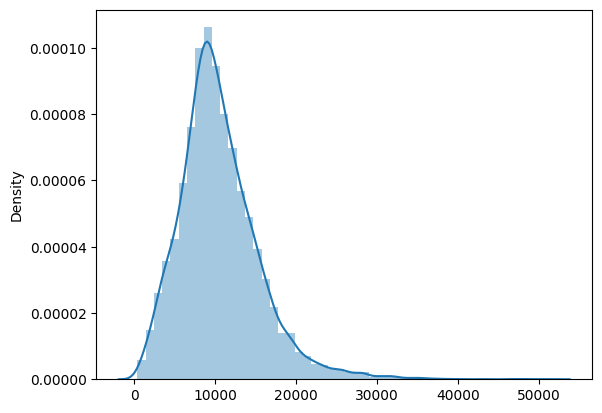

In [103]:
# Plot area distribution

sns.distplot(areas)

/tmp/ipykernel_9764/1886621256.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tau_intensity)


<AxesSubplot: ylabel='Density'>

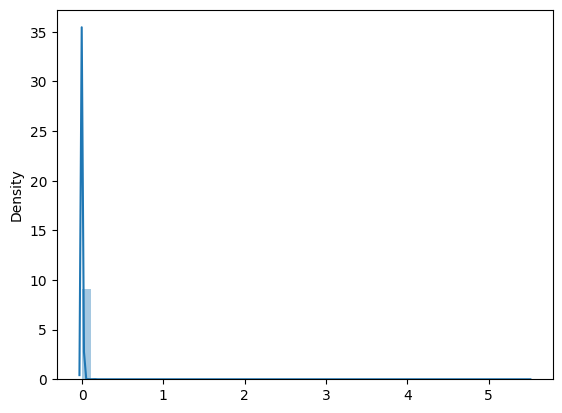

In [104]:
# Plot tau distribution

sns.distplot(tau_intensity)

/tmp/ipykernel_9764/4001847847.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(gfap_intensity)


<AxesSubplot: ylabel='Density'>

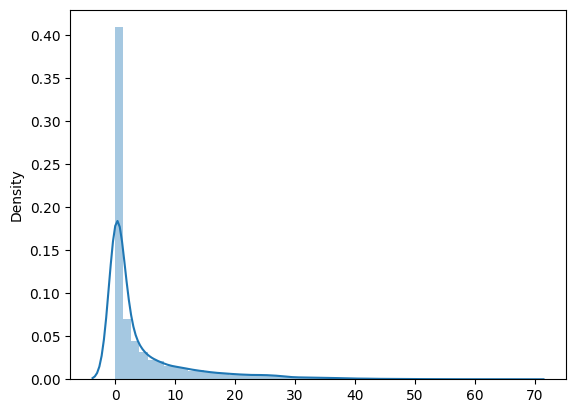

In [105]:
# Plot Gfap distribution

sns.distplot(gfap_intensity)

## Check expression pattern

In [106]:
# Get assigned reads 
assigned_index = np.argwhere(reads_assignment != 0).flatten()
assigned_bases = bases[assigned_index]
assigned_points = points[assigned_index, :]

In [107]:
gene = 'APOE'
curr_index = np.argwhere(assigned_bases == genes2seqs[gene]).flatten()
curr_points = assigned_points[curr_index, :]
print(f"Number of reads: {curr_points.shape[0]}")

Number of reads: 91777


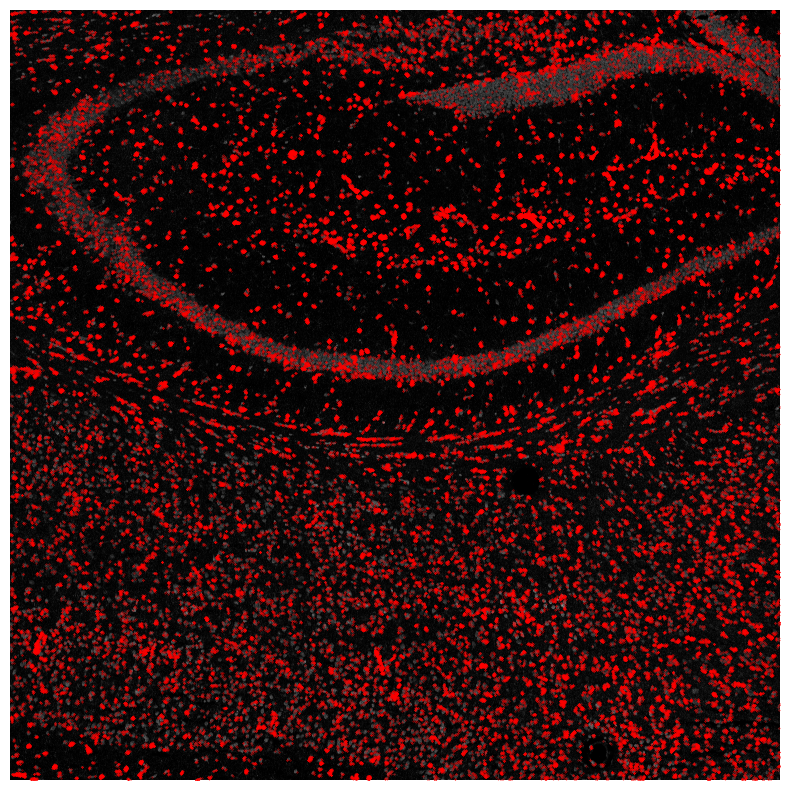

In [108]:
# Plot dots on segmentation mask
plt.figure(figsize=(10, 10))
plt.imshow(nissl, cmap='gray')
plt.plot(curr_points[:, 1], curr_points[:, 0], '.', color='red', markersize=.5)
plt.axis('off')
plt.show()

In [109]:
# Get read quantification for each gene after read assignemnt 
per_gene_expr = pd.DataFrame({'gene': list(seqs2genes.values()), 'expr': cell_by_barcode.sum(axis=0)})
per_gene_expr = per_gene_expr.sort_values('expr', ascending=False, ignore_index=True)
per_gene_expr.head(20)

,gene,expr
0,SLC17A7,278200.0
1,CALM1,247247.0
2,GPM6A,191373.0
3,CST3,165674.0
4,MBP,135735.0
5,TMSB4X,105046.0
6,TSPAN7,100588.0
7,CPLX1,100112.0
8,APOE,91777.0
9,BSG,90569.0


In [110]:
selected_genes = list(genes2seqs.keys())
expr_figure_out_path = os.path.join(expr_out_path, 'figures')
if not os.path.exists(expr_figure_out_path):
    os.mkdir(expr_figure_out_path)
    
for i, gene in enumerate(selected_genes):
    
    curr_index = np.argwhere(assigned_bases == genes2seqs[gene]).flatten()
    curr_points = assigned_points[curr_index, :]
    n_reads = curr_points.shape[0]

    # Plot
    plt.figure(figsize=(10, 10))
    plt.imshow(nissl, cmap='gray')
    plt.plot(curr_points[:, 1], curr_points[:, 0], '.', color='red', markersize=.5)
    plt.axis('off')
    expr_figure_path = os.path.join(expr_figure_out_path, f"{i+1}.{gene}_{n_reads}.png")
    plt.savefig(expr_figure_path)
    plt.clf()
    plt.close()

## Generate complete matrix for all samples

In [111]:
# Construct complete matrix
cell_by_gene_complete = None
meta_complete = None

# a = sample_dirs[0:1]
#for i, d in enumerate(sample_dirs[3:4]): ### DEBUG: Currently each sample is run individually
for i, d in enumerate(sample_dirs):
    print(f"Loading sample: {d}")
    #current_expr_path = os.path.join(out_path, d) ### DEBUG: missing intermediate folder
    current_expr_path = os.path.join(out_path, d, 'trimmed_images')
    current_expr = np.loadtxt(os.path.join(current_expr_path, "cell_barcode_count.csv"), dtype=int, delimiter=',')
    current_meta = pd.read_csv(os.path.join(current_expr_path, "meta.csv"))
    
    # add to complete matrix
    if cell_by_gene_complete is not None:
        cell_by_gene_complete = np.concatenate((cell_by_gene_complete, current_expr))
    else:
        cell_by_gene_complete = current_expr
        
    if meta_complete is not None:
        meta_complete = pd.concat([meta_complete, current_meta])
    else:
        meta_complete = current_meta
        
np.savetxt(os.path.join(out_path, "complete_cell_barcode_count.csv"), cell_by_gene_complete.astype(np.int), delimiter=',', fmt="%d")
meta_complete = meta_complete.reset_index(drop=True)
meta_complete = meta_complete.rename(columns={"Unnamed: 0": "orig_index"})
meta_complete.to_csv(os.path.join(out_path, "complete_meta.csv"))
cell_barcode_names.to_csv(os.path.join(out_path, "cell_barcode_names.csv"), header=False) ### DEBUG: Needed for next script "2. cell type classification" assuming it is identical for all samples

Loading sample: 13months_control-ADmouse_9930
Loading sample: 13months_disease-ADmouse_9919
Loading sample: 8months_control-ADmouse_9781
Loading sample: 8months_disease-ADmouse_9721


/tmp/ipykernel_9764/1784479359.py:25: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.savetxt(os.path.join(out_path, "complete_cell_barcode_count.csv"), cell_by_gene_complete.astype(np.int), delimiter=',', fmt="%d")


In [112]:
meta_complete.shape

(40952, 7)

In [113]:
cell_by_gene_complete.shape

(40952, 64)

In [114]:
meta_complete

,orig_index,sample,area,tau,gfap,x,y
0,0,13months_control-ADmouse_9930/trimmed_images,4997.0,0.0,0.84,13895,26
1,1,13months_control-ADmouse_9930/trimmed_images,5547.0,0.0,7.46,15153,19
2,2,13months_control-ADmouse_9930/trimmed_images,11679.0,0.0,0.00,9382,44
3,3,13months_control-ADmouse_9930/trimmed_images,9412.0,0.0,0.01,10499,31
4,4,13months_control-ADmouse_9930/trimmed_images,6667.0,0.0,0.00,12106,29
...,...,...,...,...,...,...,...
40947,9386,8months_disease-ADmouse_9721/trimmed_images,5245.0,0.0,2.27,20906,19594
40948,9387,8months_disease-ADmouse_9721/trimmed_images,14926.0,0.0,0.54,9942,19577
40949,9388,8months_disease-ADmouse_9721/trimmed_images,9997.0,0.0,0.61,11374,19572
40950,9389,8months_disease-ADmouse_9721/trimmed_images,4995.0,0.0,0.00,21871,19593


/tmp/ipykernel_9764/1176546084.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(meta_complete['area'])


<AxesSubplot: xlabel='area', ylabel='Density'>

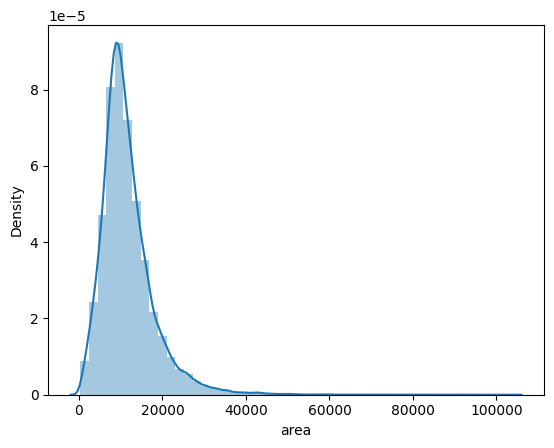

In [115]:
sns.distplot(meta_complete['area'])